# 게임 League of Legend 에서 승리하는데 영향을주는 요소들은 무엇일까? (수정본)  
### 1.실력이 좋은(티어가 높은) 플레이어 일수록 티어와 정비례하며 높아지거나 반비례 하는 수치가 있을것이다.  
### 2.승리한 팀과 연관이 있는 자료들이 있을 것이다.  
### 3.실력이 좋은 플레이어가 가지는 높은 수치들이 승률에 영향을 미칠것이다.




----------

# 수정내용
승리에 영향을 미치는 요인에 대해서 t-test 등의 데이터 검증을 통해 타당성을 증명하면 좋을 것 같다. ->가설검정을 실시함

각 티어별로 나타낸 바 그래프에 꺾은선 그래프를 추가하면 막대그래프만 있는 것보다는 티어 간에 차이를 더 쉽게 알 수 있을 것 같다. -> 꺾은선 그래프를 새로 그려서 나타냄.

나머지 티어의 데이터도 함께 분석하면 좋을 것 같다. -> 나머지 티어의 데이터들 또한 분석한다면 좋겠지만, 챌린저 그랜드마스터 마스터 사이의 실력의 차이도 분명히 존재하며 데이터 양이 많아서 이를 충분히 보여줄 수 있다. 그리고 나머지 티어의 유저들은 게임에 능숙하지 못한 유저들(게임의 이해도가 부족한 유저들)이라 양질의 데이터라고 판단하기 힘들다. 또한 나머지 티어의 데이터를 구하기 위해선 롤 API에서 데이터 크롤링을 해야하지만 실력이 부족하기도 하다.

-------

In [1]:
import numpy as np
import numpy.random as random
import scipy as sp
import scipy.stats as stats
import pandas as pd
from pandas import Series, DataFrame

# 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 소수점 3자리까지 표시
%precision 3

Cha_data = pd.read_csv('Challenger_Ranked_Games.csv')
Grm_data = pd.read_csv('GrandMaster_Ranked_games.csv')
Mas_data = pd.read_csv('Master_Ranked_Games.csv')

### 데이터 출처와 설명
https://www.kaggle.com/gyejr95/league-of-legends-challenger-ranked-games2020  
League Of Legneds High elo Ranked Games(2020)  
챌린저,그랜드마스터,마스터 티어 유저들의 2020년 게임 데이터

### 컬럼 설명  
- gameID - 게임 번호  
- gameDuraton - 게임 시간(길이)  
---------------------------------------------------------
- blueWins - 블루팀 승리 이겼을시 1  
---------------------------------------------------------
- blueFirstBlood - 블루팀이 첫번째 킬을 함  
- blueFirstTower - 블루팀이 첫번째 타워를 부숨    
- blueFirstBaron - 블루팀이 첫번째 바론을 죽임  
- blueFirstDragon - 블루팀이 첫번째 용을 죽임  
- blueFirstInhibitor - 블루팀이 첫번째 억제기를 부숨  
---------------------------------------------------------  
- blueDragonKills - 블루팀이 용을 죽인 횟수  
- blueBaronKills - 블루팀이 바론을 죽인 횟수  
- blueTowerKills - 블루팀이 부순 포탑 개수  
- blueInhibitorKills - 블루팀이 부순 억제기 개수  
- blueWardPlaced - 블루팀이 설치한 와드 개수  
---------------------------------------------------------  
- blueWardkills - 블루팀이 제거한 와드 개수  
- blueKills - 블루팀이 상대방을 죽인 횟수  
- blueDeath - 블루팀이 죽은 횟수  
- blueAssist - 블루팀의 킬관여(상대팀을 죽이는데 도움을 줌)의 횟수  
---------------------------------------------------------  
- blueChampionDamageDealt - 블루팀이 상대방 챔피언(캐릭터)에 준 데미지  
- blueTotalGold - 블루팀이 벌어들인 골드(돈)의 총합  
- blueTotalMinionKills - 블루팀이 죽인 미니언수의 총합 
- blueTotalLevel - 블루팀 캐릭터들의 레벨의 합
- blueAvgLevel - 블루팀 캐릭터의 평균 레벨  
---------------------------------------------------------  
- blueJungleMinionKIlls - 정글에 있는 정글몬스터들을 죽인 총합  
- blueKillingSpree - 블루팀 멀티킬(한번에 연속 킬) 횟수의 총합  
- blueTotalHeal - 블루팀 회복량의 총합  
- blueObjectDamageDealt - 블루팀이 오브젝트에 준 데미지의 총합

### League Of Legend의 티어 시스템
롤에서 티어는 아이언, 브론즈, 실버, 골드, 플래티넘, 다이아몬드, 마스터, 그랜드마스터, 챌린저가 존재한다. 챌린저 티어의 유저들은 상위 0.0084%, 그랜드마스터는 상위 0.02%, 마스터 유저들은 상위 0.05%의 유저들이다.

### 데이터 처리하기
Blue팀과 Red 팀의 데이터가 존재하는데 Red팀의 데이터는 블루팀의 데이터의 반대
결과 이므로(ex BlueWins =1이면 RedWins=0) 반대 결과인 데이터들을 삭제  

게임시간이 300이하인 데이터들은 처음에 한명이 나가서 롤 시스템상 다시하기로 기록되는 데이터이므로 제외

In [2]:
Challenger = Cha_data.drop(['redWins', 'redFirstBlood', 'redFirstTower',
       'redFirstBaron', 'redFirstDragon', 'redFirstInhibitor',
       'redWardPlaced', 'redWardkills', 'redKills', 'redDeath', 'redAssist',
       'redDragonKills', 'redBaronKills', 'redTowerKills', 'redInhibitorKills',
       'redChampionDamageDealt', 'redTotalGold', 'redTotalMinionKills',
       'redTotalLevel', 'redAvgLevel', 'redJungleMinionKills',
       'redKillingSpree', 'redTotalHeal', 'redObjectDamageDealt'], axis = 1)
GrandMaster = Grm_data.drop(['redWins', 'redFirstBlood', 'redFirstTower',
       'redFirstBaron', 'redFirstDragon', 'redFirstInhibitor',
       'redWardPlaced', 'redWardkills', 'redKills', 'redDeath', 'redAssist',
       'redDragonKills', 'redBaronKills', 'redTowerKills', 'redInhibitorKills',
       'redChampionDamageDealt', 'redTotalGold', 'redTotalMinionKills',
       'redTotalLevel', 'redAvgLevel', 'redJungleMinionKills',
       'redKillingSpree', 'redTotalHeal', 'redObjectDamageDealt'], axis = 1)
Master = Mas_data.drop(['redWins', 'redFirstBlood', 'redFirstTower',
       'redFirstBaron', 'redFirstDragon', 'redFirstInhibitor',
       'redDragonKills', 'redBaronKills', 'redTowerKills', 'redInhibitorKills',
       'redWardPlaced', 'redWardkills', 'redKills', 'redDeath', 'redAssist',
       'redChampionDamageDealt', 'redTotalGold', 'redTotalMinionKills',
       'redTotalLevel', 'redAvgLevel', 'redJungleMinionKills',
       'redKillingSpree', 'redTotalHeal', 'redObjectDamageDealt'], axis = 1)
Challenger = Challenger.drop(Challenger[Challenger['gameDuraton'] <= 300].index)
GrandMaster = GrandMaster.drop(GrandMaster[GrandMaster['gameDuraton'] <= 300].index)
Master = Master.drop(Master[Master['gameDuraton'] <= 300].index)

Blue팀에 영향을 받는 데이터를 제외하고 영향을 받지 않은 데이터는 살린 데이터

In [3]:
Challenger2 = Cha_data.drop(['redWins', 'redFirstBlood', 'redFirstTower',
       'redFirstBaron', 'redFirstDragon', 'redFirstInhibitor'], axis = 1)
GrandMaster2 = Grm_data.drop(['redWins', 'redFirstBlood', 'redFirstTower',
       'redFirstBaron', 'redFirstDragon', 'redFirstInhibitor'], axis = 1)
Master2 = Mas_data.drop(['redWins', 'redFirstBlood', 'redFirstTower',
       'redFirstBaron', 'redFirstDragon', 'redFirstInhibitor'], axis = 1)
Challenger2 = Challenger2.drop(Challenger2[Challenger2['gameDuraton'] <= 300].index)
GrandMaster2 = GrandMaster2.drop(GrandMaster2[GrandMaster2['gameDuraton'] <= 300].index)
Master2 = Master2.drop(Master2[Master2['gameDuraton'] <= 300].index)

## 실력이 높으면 티어가 높다. 그러면 티어별로 유의미하게 차이가 나는 데이터는 없을까?

### 게임의 상황에따라 달라지는 데이터(blue팀과 red팀의 실력이 모두 반영되는 데이터) ex)Kill,Death,GameDuraton는 티어별로 차이가 있는가?

티어별로 블루팀죽음의 합

C:\Users\slims\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slims\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slims\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

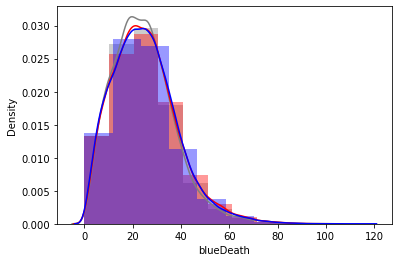

In [4]:
sns.distplot(Challenger['blueDeath'], bins = 10, 
             color = 'gray', kde = True)
sns.distplot(GrandMaster['blueDeath'], bins = 10, 
             color = 'red', kde = True)
sns.distplot(Master['blueDeath'], bins = 10, 
             color = 'blue', kde = True)

<BarContainer object of 3 artists>

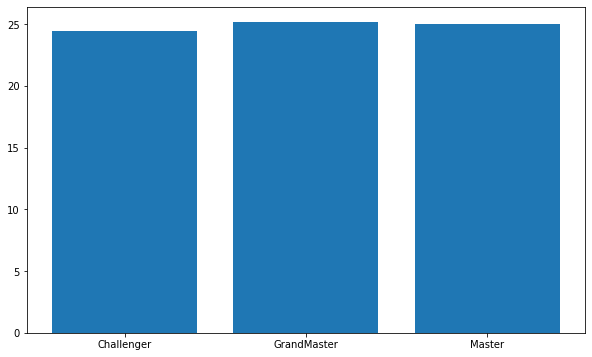

In [5]:
x = ['Challenger', 'GrandMaster', 'Master']
De = np.array([Challenger['blueDeath'].mean(), GrandMaster['blueDeath'].mean(), Master['blueDeath'].mean()])
plt.figure(figsize = (10,6))

plt.bar(x, De, label = 'Death')

### (수정) - 그래프 추가
꺾은선 그래프로 조금 더 명시적으로 나타냄

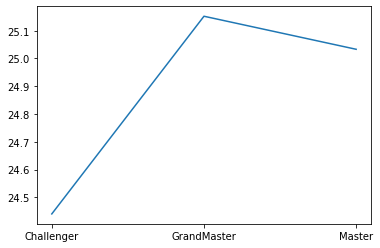

In [66]:
plt.plot(x, De)

In [7]:
print(Challenger['blueDeath'].mean(), GrandMaster['blueDeath'].mean(), Master['blueDeath'].mean())

24.440281118460614 25.152024070861668 25.033063160082374


### (수정) - 가설검정
t-test로 가설 검정을 실시

In [81]:
[t_stat, p] = stats.ttest_ind(Challenger.blueDeath, GrandMaster.blueDeath)
[t_stat, p]

[-7.3519431792747225, 1.9696407948920857e-13]

챌린저와 그랜드 마스터를 비교하였을때 p값이 0.05보다 작다. 그러므로 티어가 높아진다고 게임에서 덜 죽는다는 가정은 타당하지 않다.(우연히 이런 결과가 나오지 않앗을 것이기 때문)

### (수정) - 설명추가
티어별 시간당 죽은 횟수

<BarContainer object of 3 artists>

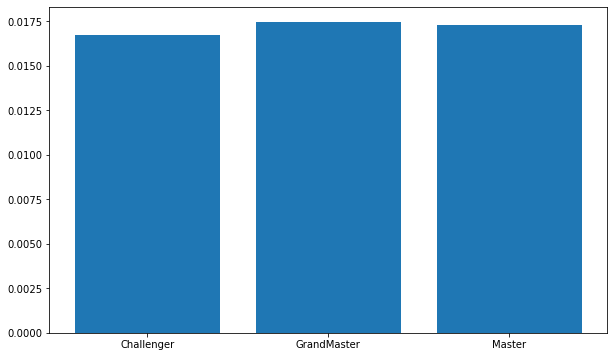

In [8]:
De2 = np.array([Challenger['blueDeath'].mean()/Challenger['gameDuraton'].mean(), GrandMaster['blueDeath'].mean()/GrandMaster['gameDuraton'].mean(), Master['blueDeath'].mean()/Master['gameDuraton'].mean()])
plt.figure(figsize = (10,6))

plt.bar(x, De2, label = 'Death/Time')

### (수정) - 그래프 추가
꺾은선 그래프로 조금 더 명시적으로 나타냄

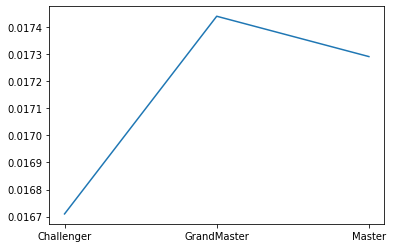

In [67]:
plt.plot(x, De2)

In [9]:
print(Challenger['blueDeath'].mean()/Challenger['gameDuraton'].mean(), GrandMaster['blueDeath'].mean()/GrandMaster['gameDuraton'].mean(), Master['blueDeath'].mean()/Master['gameDuraton'].mean())

0.01671010484854803 0.017439387164181114 0.017290539818750488


티어가 높아진다고 해서 게임에서 덜 죽는 것은 아니다.  

------------------------------------------------------------

티어별 게임시간

C:\Users\slims\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slims\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slims\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

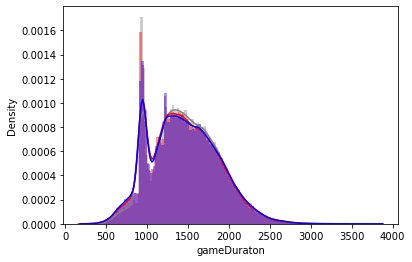

In [10]:
sns.distplot(Challenger['gameDuraton'], bins = 100, 
             color = 'gray', kde = True)
sns.distplot(GrandMaster['gameDuraton'], bins = 100, 
             color = 'red', kde = True)
sns.distplot(Master['gameDuraton'], bins = 100, 
             color = 'blue', kde = True)

### (수정) - 설명추가
1000분에서 게임 시간이 많은 분포를 보이는데, 이는 롤에서 15분이 되면 항복을 할 수 있기 때문에 15분에서 게임 시간이 많은 분포를 보인다.

<BarContainer object of 3 artists>

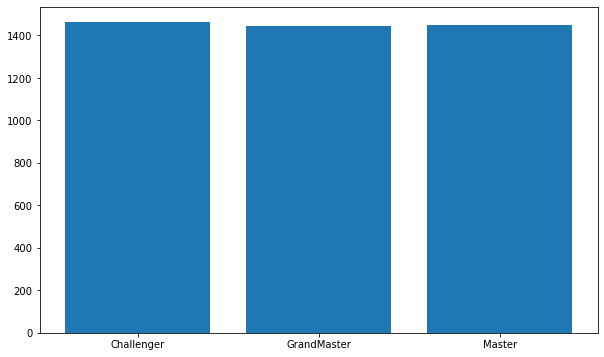

In [11]:
Ti = np.array([Challenger['gameDuraton'].mean(), GrandMaster['gameDuraton'].mean(), Master['gameDuraton'].mean()])
plt.figure(figsize = (10,6))

plt.bar(x, Ti, label = 'Death/Time')

### (수정) - 그래프 추가
꺾은선 그래프로 조금 더 명시적으로 나타냄

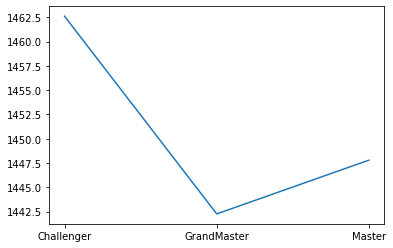

In [70]:
plt.plot(x, Ti)

In [12]:
print(Challenger['gameDuraton'].mean(), GrandMaster['gameDuraton'].mean(), Master['gameDuraton'].mean())

1462.6048932651834 1442.2538953961407 1447.7895671560013


### (수정) - 가설검정
t-test를 이용해 가설 검정을 실시

In [84]:
[t_stat, p] = stats.ttest_ind(Challenger.gameDuraton, GrandMaster.gameDuraton)
[t_stat, p]

[6.839879962448942, 7.975366643038592e-12]

In [85]:
[t_stat, p] = stats.ttest_ind(Master.gameDuraton, GrandMaster.gameDuraton)
[t_stat, p]

[2.678276733812355, 0.0074009121061367235]

첼린저와 그랜드마스터, 그랜드마스터와 마스터 모두 비교했을때 p 값이 0.05보다 작다 따라서 게임실력이 티어대별로 상관관계가 없다는 가설은 타당하다.

--------

게임 길이, 게임당 죽은 횟수는 상대팀의 실력과도 연관이 있기 때문에 티어마다 차이를 보이지 않는다. 롤의 매칭 시스템상 비슷한 실력대의 유저들이 매칭이되기 때문에 상대팀의 실력이 영향을 미치는 데이터는 티어별 실력을 나타내는데 적합하지 않은 지표라고 판단

### 게임의 환경에 영향을 미치지 않는(상대팀의 실력과 무관하게 자신의 실력만 반영되는) 지표는 티어별로 차이가 없을까?

티어별 설치한 와드의 개수

C:\Users\slims\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slims\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\slims\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

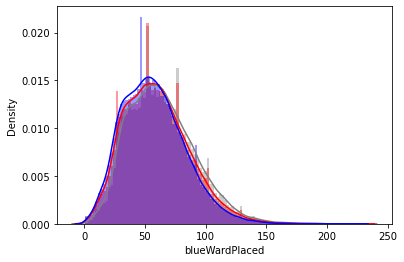

In [13]:
sns.distplot(Challenger[Challenger['blueWardPlaced'] > 0]['blueWardPlaced'], bins = 110, 
             color = 'gray', kde = True)
sns.distplot(GrandMaster[GrandMaster['blueWardPlaced'] > 0]['blueWardPlaced'], bins = 110, 
             color = 'red', kde = True)
sns.distplot(Master[Master['blueWardPlaced'] > 0]['blueWardPlaced'], bins = 110, 
             color = 'blue', kde = True)

티어별 설치한 와드 개수의 평균과 시간당 설치한 와드 개수의 평균

<BarContainer object of 3 artists>

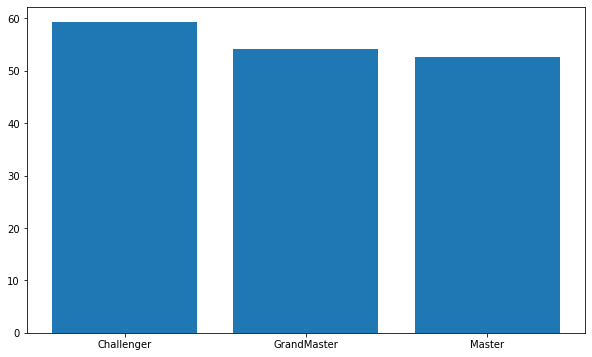

In [14]:
x = ['Challenger', 'GrandMaster', 'Master']
Ward = np.array([Challenger['blueWardPlaced'].mean(), GrandMaster['blueWardPlaced'].mean(), Master['blueWardPlaced'].mean()])
plt.figure(figsize = (10,6))

plt.bar(x, Ward, label = 'Ward')

### (수정) - 그래프 추가
꺾은선 그래프로 조금 더 명시적으로 나타냄

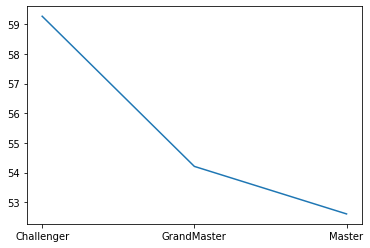

In [72]:
plt.plot(x, Ward)

In [15]:
print(Challenger['blueWardPlaced'].mean(), GrandMaster['blueWardPlaced'].mean(), Master['blueWardPlaced'].mean())

59.26379284425737 54.21014414884635 52.61057265393263


### (수정) - 가설검정
t-test를 이용해 가설 검정

In [87]:
[t_stat, p] = stats.ttest_ind(Challenger.blueWardPlaced, GrandMaster.blueWardPlaced)
[t_stat, p]

[22.456079098424954, 2.2322401581048418e-111]

In [88]:
[t_stat, p] = stats.ttest_ind(Master.blueWardPlaced, GrandMaster.blueWardPlaced)
[t_stat, p]

[-10.780384860409615, 4.347399811088787e-27]

모두 p 값이 0.05보다 작다. 가설이 적절하다

### (수정) - 설명추가
티어별 시간당 와드 설치개수

<BarContainer object of 3 artists>

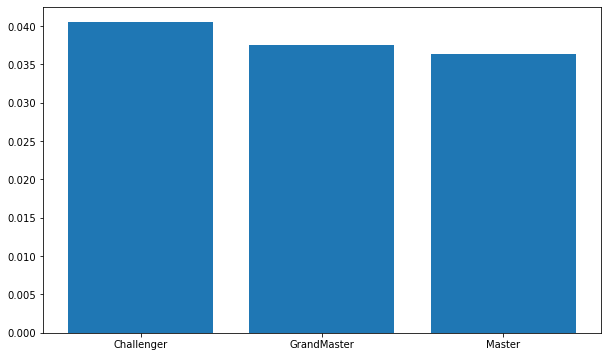

In [16]:
x = ['Challenger', 'GrandMaster', 'Master']
Ti_Ward = np.array([Challenger['blueWardPlaced'].mean()/Challenger['gameDuraton'].mean(), GrandMaster['blueWardPlaced'].mean()/GrandMaster['gameDuraton'].mean(), Master['blueWardPlaced'].mean()/Master['gameDuraton'].mean()])
plt.figure(figsize = (10,6))

plt.bar(x, Ti_Ward, label = 'Ti_Ward')

### (수정) - 그래프 추가
꺾은선 그래프로 조금 더 명시적으로 나타냄

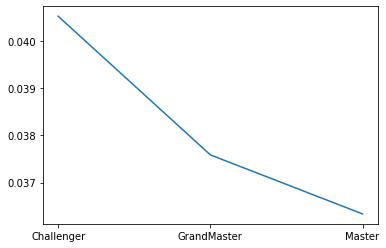

In [74]:
plt.plot(x, Ti_Ward)

In [17]:
print(Challenger['blueWardPlaced'].mean()/Challenger['gameDuraton'].mean(), GrandMaster['blueWardPlaced'].mean()/GrandMaster['gameDuraton'].mean(), Master['blueWardPlaced'].mean()/Master['gameDuraton'].mean())

0.04051934539337844 0.0375871019117314 0.03633854936341296


티어가 높아질수록 시간당 와드 개수의 평균이 많아지는걸 관찰 할 수 있다.

<BarContainer object of 3 artists>

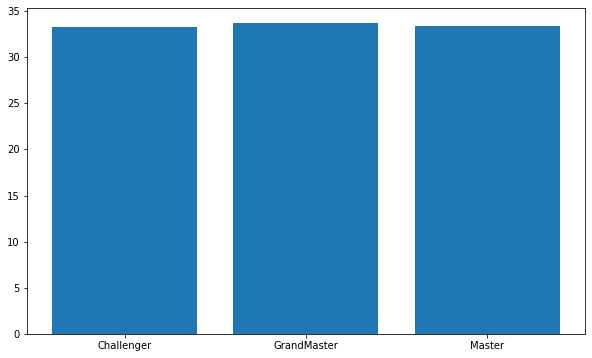

In [18]:
x = ['Challenger', 'GrandMaster', 'Master']
Gold = np.array([Challenger['blueTotalGold'].mean()/Challenger['gameDuraton'].mean(), GrandMaster['blueTotalGold'].mean()/GrandMaster['gameDuraton'].mean(), Master['blueTotalGold'].mean()/Master['gameDuraton'].mean()])
plt.figure(figsize = (10,6))

plt.bar(x, Gold, label = 'Gold')

### (수정) - 그래프 추가
꺾은선 그래프로 조금 더 명시적으로 나타냄

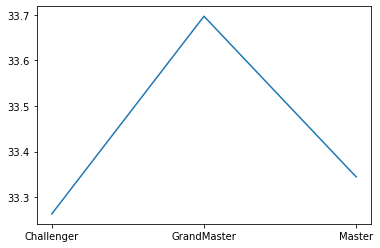

In [76]:
plt.plot(x, Gold)

In [19]:
print(Challenger['blueTotalGold'].mean()/Challenger['gameDuraton'].mean(), GrandMaster['blueTotalGold'].mean()/GrandMaster['gameDuraton'].mean(), Master['blueTotalGold'].mean()/Master['gameDuraton'].mean())

33.263070261521506 33.696835187441096 33.3443465079641


혹시 낮은 티어의 사람들이 돈(골드)를 수급하는
능력이 부족해서 와드를 더 적게 사는것 아닐까? 하여 티어별 시간당 골드 흭득량을 알아보았고 티어별로 상관관계가 없음을 알 수 있다
즉 티어가 높아질수록 와드를 많이 사는 경향성이 있다.
이는 리그오브레전드라는 게임의 이해도가 있으면 쉽게 이해할 수 있는 내용으로 킬, 게임시간 등은 모든 게임의 상황마다 자주 바뀌는 반면에
와드를 설치하는 경우는 상대의 실력 상황과는 관계없이 게임의 습관과 비슷하기 때문에 이런 결과가 나타남을 알 수 있다.

시간당 미니언

<BarContainer object of 3 artists>

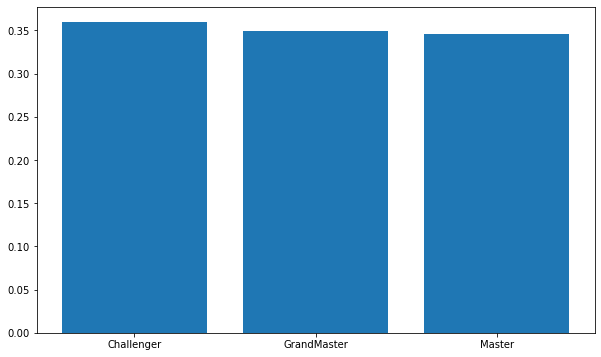

In [20]:
x = ['Challenger', 'GrandMaster', 'Master']
Cs = np.array([Challenger['blueTotalMinionKills'].mean()/Challenger['gameDuraton'].mean(), GrandMaster['blueTotalMinionKills'].mean()/GrandMaster['gameDuraton'].mean(), Master['blueTotalMinionKills'].mean()/Master['gameDuraton'].mean()])
plt.figure(figsize = (10,6))

plt.bar(x, Cs, label = 'Cs')

### (수정) - 그래프 추가
꺾은선 그래프로 조금 더 명시적으로 나타냄

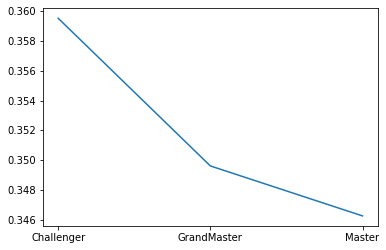

In [77]:
plt.plot(x, Cs)

In [21]:
print(Challenger['blueTotalMinionKills'].mean()/Challenger['gameDuraton'].mean(), GrandMaster['blueTotalMinionKills'].mean()/GrandMaster['gameDuraton'].mean(), Master['blueTotalMinionKills'].mean()/Master['gameDuraton'].mean())

0.3595244555263792 0.3496070207065021 0.34625081302957195


마찬가지로 시간당 미니언도 티어가 높아질수록 더 잘 처치하는 경향을 보인다. (= 실력이 좋은 유저는 미니언을 처치하면서 실수하지 않는다.)

체스에서 기물을 많이 잡는 것이 실력을 나타내는 지표가 아니듯이 롤에서 킬을 많이하는 것이 실력을 나타내는 지표는 아니다.  
물론 비슷하지 않은 실력의 사람들이 맞붙는다면 실력이 좋은 사람이 자신의 기물은 적게 죽이고 상대방의 기물은 많이 처치할 것이다. 하지만 실력이 비슷한 사람들끼리 체스에서 맞붙는다면 게임에서 기물을 많이 죽인것이 실력을 나타내는 지표가 아니며(왜냐하면 비슷한 실력대의 사람들이 맞붙기 때문에 어떤 게임에선 적은기물이 죽고, 어떤 게임에선 많은 기물이 죽을 것이다), 게임 시간을 빨리 끝내거나, 늦게 끝낸다고 실력을 나타내는 지표로 사용할 수 없는 것처럼 롤에서도 결국은 잘하는 유저들은 잘하는 티어에, 못하는 유저들은 못하는 티어에 위치하기 때문에 티어별 매칭의 결과에서 킬을 많이 하는 것과 게임시간을 객관적인 실력을 나타내는 지표로 사용하기엔 알맞지 않다. 즉 이러한 지표들은 비슷한 실력의 유저들이 만나면 평균적으로 그 게임에서 이정도로 킬을 하고 게임의 길이는 이정도 라는 지표를 각각 나타낸것과 같다.    
마스터에서 그랜드마스터, 그랜드마스터에서 챌린저 상위 티어로 갈수록 실력이 좋은것은 분명하다. 그렇지만, 킬 등의 수치는 실력을 보기에는 적절치 않은 지표이므로 새로운 지표를 탐색하였고, 티어가 올라감에따라 같이 상승하는 지표들이 있었다. 이는 상대방의 실력과는 관계없이 본인의 플레이만 잘하면 잘 나오는 수치이므로 그들의 실력을 잘 반영한다고 볼 수도 있다. 이 뒤부터는 이 지표가 승률에 영향을 미쳐서 그들이 높은 티어에 위치하고 있는가? 에 대한 의문을 해결하기 위한 답변들이다


-------------------

### 모든 데이터를 합쳐서 통합된 약 10000개의 행을 가진 자료를 얻음

In [22]:
df1 = pd.merge(Challenger, GrandMaster)
df2 = pd.merge(df1, Master)
df2

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,blueAssist,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueTotalLevel,blueAvgLevel,blueJungleMinionKills,blueKillingSpree,blueTotalHeal,blueObjectDamageDealt
0,4219545724,1313,0,0,1,0,0,0,0,0,...,9,36087,35880,563,56,11.2,119,1,13059,26348
1,4219463634,1660,1,0,0,1,1,1,1,1,...,61,64708,58214,651,74,14.8,209,7,37288,64577
2,4205778093,984,1,1,1,0,1,0,2,0,...,34,45772,36545,402,53,10.6,102,6,14093,31303
3,4169807983,1109,1,0,1,0,1,0,2,0,...,30,52628,37722,484,58,11.6,111,4,20715,38287
4,4158792026,1845,1,1,1,0,1,1,4,1,...,58,84049,65775,690,79,15.8,221,9,26997,89993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,4167348313,2049,0,1,1,0,1,0,2,0,...,35,108326,62122,766,79,15.8,181,8,20604,45077
10076,4190417319,1711,1,1,0,1,1,1,4,1,...,41,86888,56699,607,73,14.6,183,9,46662,72302
10077,4139037171,1212,1,1,0,0,0,1,2,0,...,28,42281,41367,509,58,11.6,118,5,14893,48971
10078,4087132870,1828,1,0,1,0,1,1,3,0,...,35,74838,60024,781,74,14.8,214,6,43116,79940


In [23]:
df3 = pd.merge(Challenger2, GrandMaster2)
df4 = pd.merge(df3, Master)
df4

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,4219545724,1313,0,0,1,0,0,0,0,0,...,43,52924,39672,510,63,12.6,133,4,12252,29828
1,4219463634,1660,1,0,0,1,1,1,1,1,...,22,61745,46516,630,65,13.0,153,2,17005,37066
2,4205778093,984,1,1,1,0,1,0,2,0,...,5,25007,21444,304,41,8.2,51,1,10499,3085
3,4169807983,1109,1,0,1,0,1,0,2,0,...,12,45339,29401,402,51,10.2,92,2,24150,11133
4,4158792026,1845,1,1,1,0,1,1,4,1,...,39,60275,60427,751,75,15.0,158,6,15773,40996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,4167348313,2049,0,1,1,0,1,0,2,0,...,54,96754,68342,793,84,16.8,228,9,44690,77897
10076,4190417319,1711,1,1,0,1,1,1,4,1,...,26,70583,47900,554,64,12.8,138,4,22467,10132
10077,4139037171,1212,1,1,0,0,0,1,2,0,...,12,27527,33845,434,52,10.4,117,1,16419,22594
10078,4087132870,1828,1,0,1,0,1,1,3,0,...,41,79836,54977,722,70,14.0,149,5,24411,49704


### 승리(blueWins)와 관련이 있는 지표는 없을까?

BlueWins와 다른 수치간의 선형 상관관계(Pearson correlation)을 계산하고 소팅

In [24]:
df2.corrwith(df2.blueWins).sort_values(ascending = False)

blueWins                   1.000000
blueTowerKills             0.739213
blueFirstInhibitor         0.652176
blueObjectDamageDealt      0.596099
blueInhibitorKills         0.569540
blueKills                  0.556711
blueDragonKills            0.532990
blueKillingSpree           0.515476
blueAssist                 0.497213
blueFirstTower             0.455596
blueFirstBaron             0.398224
blueBaronKills             0.390602
blueTotalGold              0.314880
blueFirstDragon            0.300660
blueJungleMinionKills      0.282774
blueAvgLevel               0.268591
blueTotalLevel             0.268591
blueTotalHeal              0.227405
blueFirstBlood             0.210882
blueChampionDamageDealt    0.189943
blueTotalMinionKills       0.099288
blueWardkills              0.093853
blueWardPlaced             0.049703
gameDuraton               -0.005947
gameId                    -0.018662
blueDeath                 -0.567124
dtype: float64

BlueWins와 다른 수치간의 상관관계를 Spearman correlation 으로 구함

In [25]:
df2.corrwith(df2.blueWins, method = 'spearman').sort_values(ascending = False)

blueWins                   1.000000
blueTowerKills             0.740856
blueInhibitorKills         0.657808
blueFirstInhibitor         0.652176
blueObjectDamageDealt      0.614948
blueKills                  0.576731
blueDragonKills            0.548800
blueKillingSpree           0.537854
blueAssist                 0.523087
blueFirstTower             0.455596
blueBaronKills             0.412410
blueFirstBaron             0.398224
blueTotalGold              0.311127
blueFirstDragon            0.300660
blueJungleMinionKills      0.291684
blueTotalLevel             0.259195
blueAvgLevel               0.259195
blueTotalHeal              0.251757
blueFirstBlood             0.210882
blueChampionDamageDealt    0.201298
blueWardkills              0.100615
blueTotalMinionKills       0.081048
blueWardPlaced             0.048872
gameDuraton               -0.008790
gameId                    -0.027899
blueDeath                 -0.586896
dtype: float64

blueTowerKills, blueFirstInhibitor, blueInhibitorKills, blueObjectDamageDealt가 높은 상관관계를 가지고 있다.

### (수정) - 가설검정
모든 값들에 대해 t-test로 가설 검정을 실시 하였다.

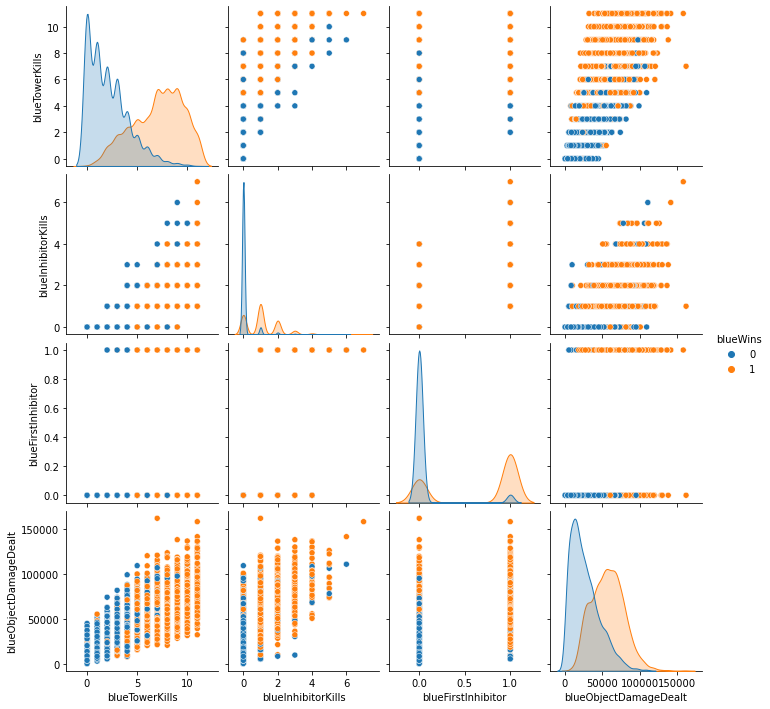

In [26]:
sns.pairplot(df2, hue = 'blueWins', vars = ['blueTowerKills', 'blueInhibitorKills', 'blueFirstInhibitor', 'blueObjectDamageDealt'])

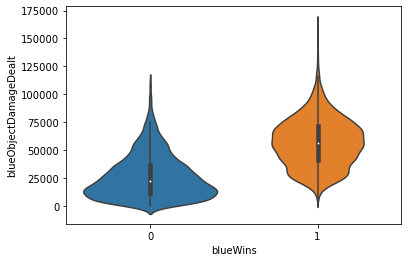

In [27]:
sns.violinplot(x = 'blueWins', y = 'blueObjectDamageDealt', data = df2)

In [90]:
[t_stat, p] = stats.ttest_ind(df2[df2.blueWins == 1].blueObjectDamageDealt, df2[df2.blueWins == 0].blueObjectDamageDealt)
[t_stat, p]

[74.53124119881376, 0.0]

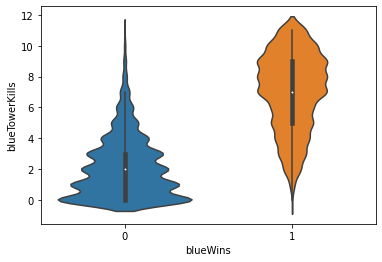

In [28]:
sns.violinplot(x = 'blueWins', y = 'blueTowerKills', data = df2)

In [91]:
[t_stat, p] = stats.ttest_ind(df2[df2.blueWins == 1].blueTowerKills, df2[df2.blueWins == 0].blueTowerKills)
[t_stat, p]

[110.18869079226226, 0.0]

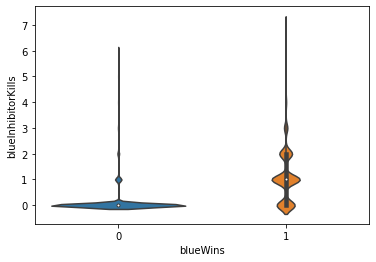

In [29]:
sns.violinplot(x = 'blueWins', y = 'blueInhibitorKills', data = df2)

In [92]:
[t_stat, p] = stats.ttest_ind(df2[df2.blueWins == 1].blueInhibitorKills, df2[df2.blueWins == 0].blueInhibitorKills)
[t_stat, p]

[69.5599231808049, 0.0]

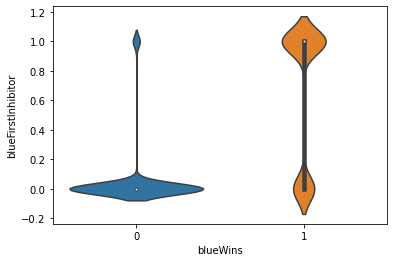

In [30]:
sns.violinplot(x = 'blueWins', y = 'blueFirstInhibitor', data = df2)

In [93]:
[t_stat, p] = stats.ttest_ind(df2[df2.blueWins == 1].blueFirstInhibitor, df2[df2.blueWins == 0].blueFirstInhibitor)
[t_stat, p]

[86.36616297943574, 0.0]

승리한 팀은 타워를 많이 파괴하고,억제기를 많이 부수고, 억제기를 먼저 부수고, 오브젝트에 데미지를 많이준 팀이 많이 승리했다

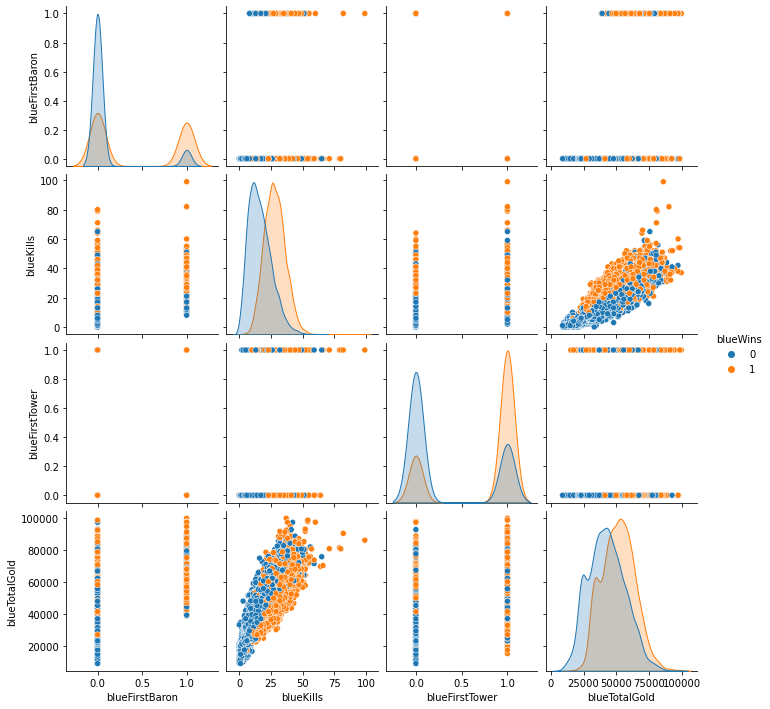

In [31]:
sns.pairplot(df2, hue = 'blueWins', vars = ['blueFirstBaron', 'blueKills', 'blueFirstTower', 'blueTotalGold'])

승리한 팀은 첫번째 바론을 잡고, 첫번째 포탑을 부수고, 더 많은 킬을 하고, 더 많은 골드를 흭득했다

승리와 와드설치 개수의 pairtplot

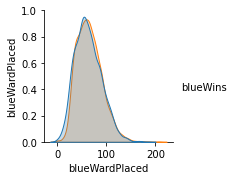

In [32]:
sns.pairplot(df2, hue = 'blueWins', vars = ['blueWardPlaced'])

### (수정) - 가설검정
t-test로 가설검정 실시

In [94]:
[t_stat, p] = stats.ttest_ind(df2[df2.blueWins == 1].blueWardPlaced, df2[df2.blueWins == 0].blueWardPlaced)
[t_stat, p]

[4.995858272140725, 5.95578226060799e-07]

p값이 0.05보다 작으므로 우연히 이런 결과가 나오진 않았을 것이다.

### 와드는 승리와 관련이 없어 보인다. 앞에서 분석한 결과와 다른데 정말 그럴까?

In [33]:
df2['New_Ward'] = df4['blueWardPlaced'] - df4['redWardPlaced'] # 블루팀 와드 설치 개수 - 레드팀 와드 설치 개수 열을 추가
df2['New_Ward']

0       -19
1       -12
2        22
3       -11
4       -14
         ..
10075   -13
10076    -6
10077    -3
10078   -21
10079    22
Name: New_Ward, Length: 10080, dtype: int64

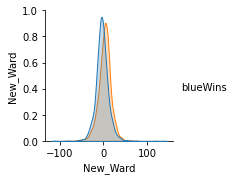

In [34]:
sns.pairplot(df2, hue = 'blueWins', vars = ['New_Ward'])

<function matplotlib.pyplot.show(*args, **kw)>

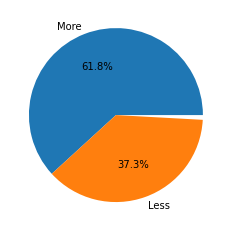

In [35]:
ratio_Ward = [np.sum(df2[df2.New_Ward > 0].blueWins)/len(df2[df2.New_Ward > 0]),
             np.sum(df2[df2.New_Ward < 0].blueWins)/len(df2[df2.New_Ward < 0])]
labels = ['More', 'Less']

plt.pie(ratio_Ward, labels = labels, autopct = '%.1f%%')
plt.show

In [36]:
np.sum(df2[df2.New_Ward > 0].blueWins)/len(df2[df2.New_Ward > 0]) # 상대팀 보다 와드설치를 많이 했을때 승률

0.6179588443151112

In [37]:
np.sum(df2[df2.New_Ward == 0].blueWins)/len(df2[df2.New_Ward == 0]) # 상대팀과 와드설치 개수가 같을때 승률

0.4662379421221865

In [38]:
np.sum(df2[df2.New_Ward < 0].blueWins)/len(df2[df2.New_Ward < 0]) # 상대팀 보다 와드 설치를 적게 했을때 승률

0.37333602258975396

롤 매칭 시스템상 비슷한 실력대의 유저가 매칭되기에 승/패 결과로는 와드의 개수가 승리와 연관이 없어보인다 하지만, 와드의 개수의 차를 구한뒤 승률을 구하면 와드를 많이 설치한 팀이 승률이 62퍼센트, 와드를 적게 설치한 팀이 승률이 37퍼센트로 와드는 승률과 직접적인 연관이 있고 많이 설치할 수록 많이 이기는 경향이 있다고 판단할 수 있다.

In [39]:
df2['New_TotalMinionKills'] = (df4['blueTotalMinionKills'] - df4['redTotalMinionKills'])/df4['gameDuraton'].mean()
df2['New_TotalMinionKills'] # 시간당 미니언 처치 수에 관한 새로운 열 생성

0        0.035676
1        0.014136
2        0.065966
3        0.055196
4       -0.041061
           ...   
10075   -0.018174
10076    0.035676
10077    0.050484
10078    0.039714
10079   -0.013462
Name: New_TotalMinionKills, Length: 10080, dtype: float64

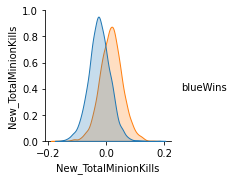

In [40]:
sns.pairplot(df2, hue = 'blueWins', vars = ['New_TotalMinionKills'])

<function matplotlib.pyplot.show(*args, **kw)>

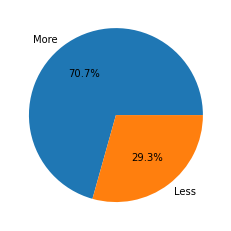

In [41]:
ratio_Minion = [np.sum(df2[df2.New_TotalMinionKills > 0].blueWins)/len(df2[df2.New_TotalMinionKills > 0]),
             np.sum(df2[df2.New_TotalMinionKills < 0].blueWins)/len(df2[df2.New_TotalMinionKills < 0])]

plt.pie(ratio_Minion, labels = labels, autopct = '%.1f%%')
plt.show

In [42]:
np.sum(df2[df2.New_TotalMinionKills > 0].blueWins)/len(df2[df2.New_TotalMinionKills > 0]) # 상대팀보다 시간당 미니언을 많이 처치했을때 승률

0.7268303472683034

In [43]:
np.sum(df2[df2.New_TotalMinionKills == 0].blueWins)/len(df2[df2.New_TotalMinionKills == 0])# 상대팀과 시간당 미니언 처치가 같을때 승률

0.39215686274509803

In [44]:
np.sum(df2[df2.New_TotalMinionKills < 0].blueWins)/len(df2[df2.New_TotalMinionKills < 0])# 상대팀보다 시간당 미니언을 적게 처치했을때 승률

0.3019244734931009

시간당 처치하는 미니언수도 마찬가지로 무려 시간당 미니언을 많이 먹는 팀이 73%의 승률을 보인다

In [45]:
[t_stat, p] = stats.ttest_ind(df2[(df2.New_Ward > 0)].blueWins, df2[(df2.New_Ward < 0)].blueWins)
[t_stat, p]

[24.932159025649472, 4.548195040079417e-133]

In [46]:
[t_stat, p] = stats.ttest_ind(df2[(df2.New_TotalMinionKills > 0)].blueWins, df2[(df2.New_TotalMinionKills < 0)].blueWins)
[t_stat, p]

[46.728787225144785, 0.0]

즉 실력이 더 좋음을 나타내는 지표가 높으면 게임에서 이길 확률이 높아진다

### 이긴 팀이 단지 적을 많이처치한걸까 아니면 적을 많이 처치한 팀이 이긴걸까?  

In [47]:
df2['New_Kills'] = df4['blueKills'] - df4['redKills']
df2['New_Kills']

0       -16
1        17
2        23
3        10
4        10
         ..
10075   -12
10076    17
10077    14
10078    -1
10079    13
Name: New_Kills, Length: 10080, dtype: int64

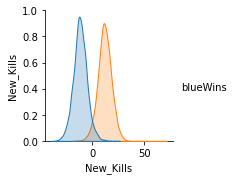

In [48]:
sns.pairplot(df2, hue = 'blueWins', vars = ['New_Kills'])

In [49]:
np.sum(df2[df2.New_Kills > 0].blueWins)/len(df2[df2.New_Kills > 0])

0.9604040404040404

In [50]:
np.sum(df2[df2.New_Kills == 0].blueWins)/len(df2[df2.New_Kills == 0])

0.5384615384615384

In [51]:
np.sum(df2[df2.New_Kills < 0].blueWins)/len(df2[df2.New_Kills < 0])

0.03163549542379626

킬을 많이한 팀은 96퍼센트의 승률, 적게한 팀은 3퍼센트의 승률을 보인다. 킬,포탑 철거 등의 데이터는 앞에서 언급한것처럼 상대방의 실력에따라 그 값이 많이 변하고, 한 게임의 현상을 나타내는 지표라고 보면된다. 당연하게도 킬(체스에서 기물을 상대방보다 많이 잡는 것)은 승리와 연관이 있을 것이다.  

그렇다면 처음으로 킬(FirstBlood)을 한팀의 승률은 어떻게 될까?

In [52]:
np.sum(df2[df2.blueFirstBlood == 1].blueWins)/len(df2[df2.blueFirstBlood == 1])

0.5973668697190018

In [53]:
np.sum(df2[df2.blueFirstBlood == 0].blueWins)/len(df2[df2.blueFirstBlood == 0])

0.38649569224604285

킬이 승리의 중요한 요인인 만큼 처음으로 킬을 만들어내는 팀이 승률이 60%로 높았다.  
즉 자신이 하는 모든 게임의 승률을 높이기 위해선 자신의 와드를 많이 설치하고, 시간당 미니언 처치수를 늘리기 위해 노력해야 하며 자신이 지금 당장 하고 있는 하나의 게임을 이기기 위해선 상대방을 많이 죽이고, 포탑을 많이 철거하고, 억제기를 많이 파괴하고 또 먼저 죽이고 철거하고 파괴해야한다는 점을 나타낸다.

돈을 더 많이 가진 팀이 이기지 않았을까?

In [54]:
df2['New_Gold'] = df4['blueTotalGold'] - df4['redTotalGold']
df2['New_Gold']

0        -3792
1        11698
2        15101
3         8321
4         5348
         ...  
10075    -6220
10076     8799
10077     7522
10078     5047
10079     5535
Name: New_Gold, Length: 10080, dtype: int64

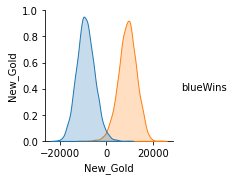

In [55]:
sns.pairplot(df2, hue = 'blueWins', vars = ['New_Gold'])

In [56]:
np.sum(df2[df2.New_Gold > 0].blueWins)/len(df2[df2.New_Gold > 0])

0.9849003422589088

In [57]:
np.sum(df2[df2.New_Gold < 0].blueWins)/len(df2[df2.New_Gold < 0])

0.01486697965571205

돈을 더 많이 가진 팀이 98퍼센트 확률로 이긴다. 상대방보다 돈이 적을 때 이길 확률은 1퍼센트 즉 상대방보다 돈을 많이 벌면 = 승리한다
앞에서 살펴본 kiil,와드 등의 지표는 골드와 어떤 상관관계가 있는지 살펴본다.

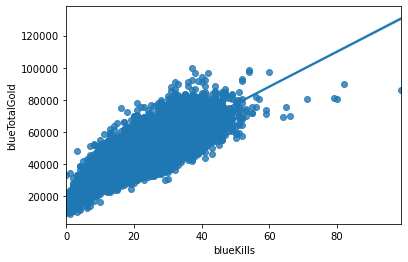

In [58]:
sns.regplot(data = df2, x = df2['blueKills'], y = df2['blueTotalGold']) # 상대방 처치 수와 얻은 골드량의 관계

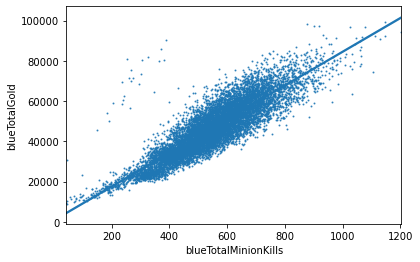

In [59]:
sns.regplot(data = df2, x = df2['blueTotalMinionKills'], y = df2['blueTotalGold'], scatter_kws = {'s':1})
# 처치한 미니언수와 얻은 골드

미니언을 많이 처치하고, 상대방을 많이 죽이는것은 골드흭득량과 상관이 있다.

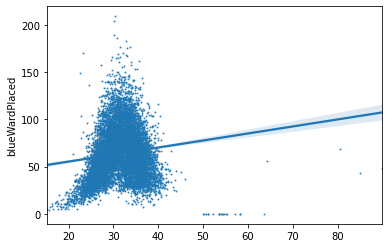

In [60]:
sns.regplot(data = df2, x = df2['blueTotalGold']/df2['gameDuraton'], y = df2['blueWardPlaced'], scatter_kws = {'s':1})
# 시간당 골드흭득량과 와드 설치량과의 관계

앞에서 언급한것처럼 시간당 골드흭득량이 높아진다고 와드를 많이 설치하지는 않는다.

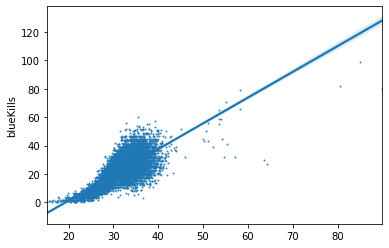

In [61]:
sns.regplot(data = df2, x = df2['blueTotalGold']/df2['gameDuraton'], y = df2['blueKills'], scatter_kws = {'s':1})
# 시간당 골드흭득량과 처치한 상대방의 수 와의 관계

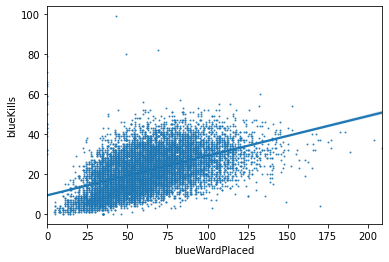

In [62]:
sns.regplot(data = df2, x = df2['blueWardPlaced'], y = df2['blueKills'], scatter_kws = {'s':1})
# 와드 설치수와 킬수의 관계

# 결론
### 1.실력이 좋은(티어가 높은) 플레이어 일수록 정비례하며 높아지거나 반비례 하는 수치가 있을것이다.  
시간당 와드 설치수, 시간당 미니언 처치수가 관련이 있었다.
### 2.승리한 팀과 연관이 있는 자료들이 있을 것이다.  
승리했을때 높은 수치들이 있었다. ex)파괴한 포탑수... 등등 하지만 1에서 찾은 값들은 승리와 연관이 없어보인다. 이는 롤의 매칭시스템상 비슷한
실력의 유저들이 매칭이 되는데 당연히 비슷한 실력의 유저들은 승/패에 관계없이 동일한 수치를 가질 것이다. 그래서 와드를 많이 설치하였을때, 적게 설치하였을 때
승률을 계산해보니 시간당 와드 설치 수는 승률과 직접적인 관련이 있었다. 시간당 미니언 처치 수도 마찬가지의 결과를 얻었다.
### 3.실력이 좋은 플레이어가 가지는 높은 수치들이 승률에 영향을 미칠것이다.
실력이 좋은 플레이어가 가지는 높은 수치들이 승률에 직접적이고 긍정적인 영향을 준다.

게임 안에서 승리에 영향을 미치는 요소는 상대방을 많이 죽이고, 포탑을 많이 부수고, 억제기를 많이 부수고, 오브젝트를 많이 죽이면 된다.  
이건 '한' 게임 안에서의 이야기고 전체적인 승률을 높이기 위해서는 시간당 와드를 많이 설치하고, 시간당 미니언을 많이 처치해야한다.